In [1]:
from pathlib import Path
import os
import json
import numpy as np
import pandas as pd
import sys
sys.path.append('../src')
from config import PROJECT_DIR, VOC_CLASSES, LABELS_DIR, TRUE_LABELS_CSV, RESULTS_DIR, HISTORIES_DIR, FIGURES_DIR
from experiment_config import experiments
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

plt.style.use('default')
experiment_count = sum(len(experiments[exp]) for exp in experiments)
os.makedirs(FIGURES_DIR, exist_ok=True)

In [2]:
# Load all experiment results into a single dataframe

all_results = pd.DataFrame()
for file_path in RESULTS_DIR.glob("*.csv"):
    exp_title = file_path.stem
    df = pd.read_csv(file_path)
    df['experiment_set'] = exp_title
    all_results = pd.concat([all_results, df], ignore_index=True)
assert len(all_results) == experiment_count

In [3]:
# Load all history files into a list of dataframes
histories = []
for history_file in sorted(HISTORIES_DIR.glob("*.csv")):
    df = pd.read_csv(history_file)
    histories.append(df)
assert len(histories) == experiment_count

In [4]:
# Load all prediction files into a list of dataframes
predictions = []
for pred_file in sorted(LABELS_DIR.glob("*.csv")):
    if pred_file == TRUE_LABELS_CSV:
        continue
    df = pd.read_csv(pred_file)
    predictions.append(df)
assert len(predictions) == 20

In [5]:
TEST_JSON = PROJECT_DIR / "data" / "preprocessed_jsons" / "test.json"

# Load test data
with open(TEST_JSON) as f:
    test_data = json.load(f)

# Process data to match the format of predicted.csv
true_labels_list = []
for item in test_data:
    image_name = item['file_path']
    labels = [0] * 20  # Assuming 20 possible labels
    for obj in item['object_labels']:
        label_index = VOC_CLASSES[obj['name']]
        labels[label_index] = 1
    true_labels_list.append([image_name] + labels)
    
# Create a DataFrame
true_labels_df = pd.DataFrame(true_labels_list, columns=['image_name'] + [str(i) for i in range(20)])

# Save to CSV
true_labels_df.to_csv(TRUE_LABELS_CSV, index=False)

In [6]:
heatmap_params = {
    'annot': True, 
    'fmt': '.3f',
    'cmap': 'RdYlGn',
    'vmin': 0.5,
    'vmax': 0.95
}

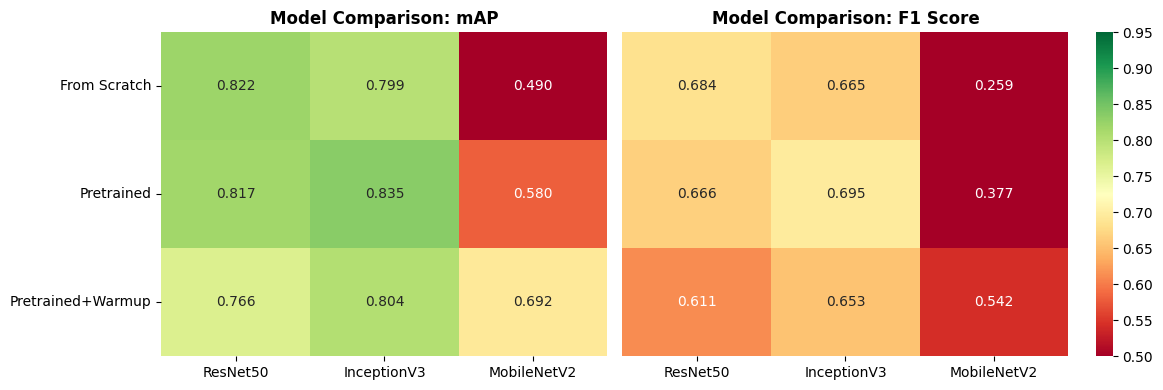

In [7]:
# Load model performance data
model_performance = all_results[all_results['experiment_set'] == 'model-experiments']

# Plot bar graphs for accuracy and F1 score
metrics = ['test_map', 'test_f1']
metric_display_names = {
    'test_map': 'mAP',
    'test_f1': 'F1 Score'
}
# Create figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 1.25]})

for idx, metric in enumerate(metrics):
    # Reshape data into matrix form
    data_matrix = np.zeros((3, 3))  # 3 training setups x 3 model types
    
    # Fill matrix with metric values
    for i, setup in enumerate(['no-pretraining no-warmup', ' pretraining no-warmup', 'pretraining warmup']):
        for j, model in enumerate(['resnet50', 'inception_v3', 'mobilenet_v2']):
            idx_model = model_performance[model_performance['title'].str.contains(model) & 
                                  model_performance['title'].str.contains(setup)].index[0]
            data_matrix[i,j] = model_performance.loc[idx_model, metric]

    sns.heatmap(data_matrix, 
                xticklabels=['ResNet50', 'InceptionV3', 'MobileNetV2'],
                yticklabels=['From Scratch', 'Pretrained', 'Pretrained+Warmup'] if idx == 0 else False,
                ax=axes[idx],
                **heatmap_params,
                cbar= idx == len(metrics)-1)
    axes[idx].set_title(f'Model Comparison: {metric_display_names[metric]}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / "model_comparison_heatmap.png")
plt.show()

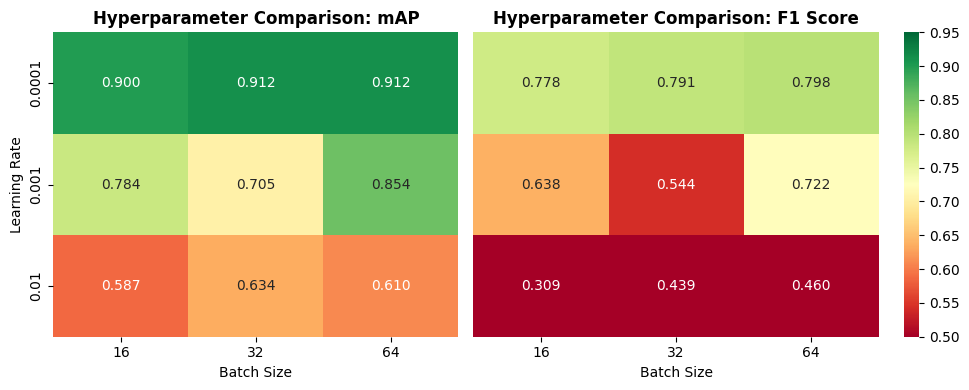

In [8]:
# Load hyperparameter performance data
hyperparameter_performance = all_results[all_results['experiment_set'] == 'hyperparameter-experiments']

# Plot bar graphs for accuracy and F1 score
metrics = ['test_map', 'test_f1']
metric_display_names = {
    'test_map': 'mAP',
    'test_f1': 'F1 Score'
}
# Create figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1.25]})

for idx, metric in enumerate(metrics):
    # Reshape data into matrix form
    data_matrix = np.zeros((3, 3))  # 3 learning rates x 3 batch sizes
    
    # Fill matrix with metric values
    for i, lr in enumerate([0.0001, 0.001, 0.01]):
        for j, bs in enumerate([16, 32, 64]):
            idx_model = hyperparameter_performance[
                hyperparameter_performance['title'].str.contains(f'batch_size={bs}') & 
                hyperparameter_performance['title'].str.contains(f'learning_rate={lr}')
            ].index[0]
            data_matrix[i,j] = hyperparameter_performance.loc[idx_model, metric]

    sns.heatmap(data_matrix, 
                xticklabels=['16', '32', '64'],
                yticklabels=['0.0001', '0.001', '0.01'] if idx == 0 else False,
                ax=axes[idx],
                **heatmap_params,
                cbar= idx == len(metrics)-1)
    axes[idx].set_title(f'Hyperparameter Comparison: {metric_display_names[metric]}', fontsize=12, fontweight='bold')
    if idx == 0:
        axes[idx].set_ylabel('Learning Rate')
    axes[idx].set_xlabel('Batch Size')

plt.tight_layout()
plt.savefig(FIGURES_DIR / "hyperparameter_comparison_heatmap.png")
plt.show()

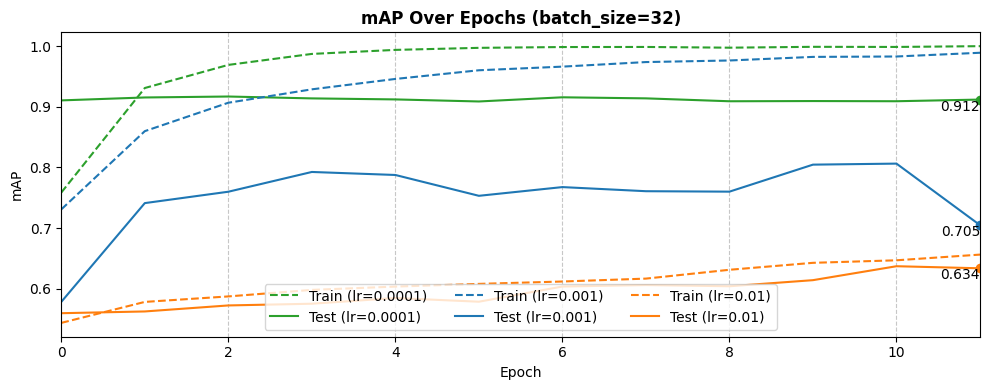

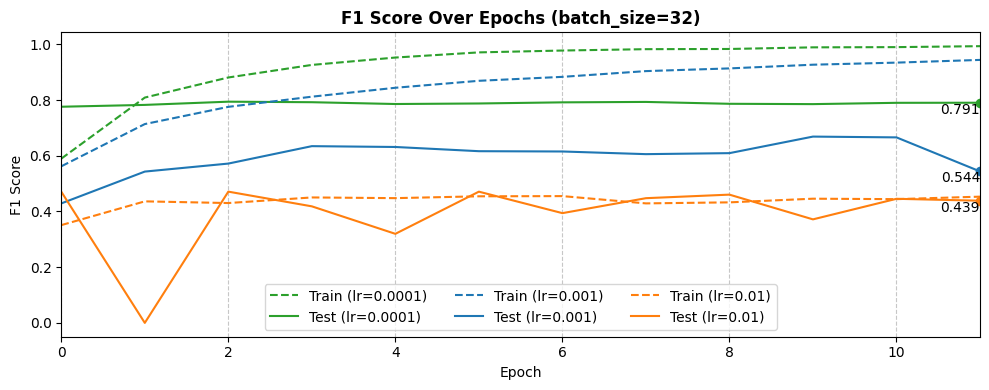

In [9]:
# Get best batch size based on test_map
best_batch_size = hyperparameter_performance.groupby('title').agg({'test_map': 'mean'}).idxmax()['test_map']
best_batch_size = int(best_batch_size.split('=')[1].split(',')[0])

# Plot learning curves for both metrics
metrics = [
    {'name': 'map', 'display': 'mAP'},
    {'name': 'f1', 'display': 'F1 Score'}
]
colors = ['#2ca02c', '#1f77b4', '#ff7f0e']

for metric in metrics:
    plt.figure(figsize=(10, 4))
    
    for i, lr in enumerate([0.0001, 0.001, 0.01]):
        model_id = hyperparameter_performance[
            hyperparameter_performance['title'].str.contains(f'batch_size={best_batch_size}') & 
            hyperparameter_performance['title'].str.contains(f'learning_rate={lr}')
        ].iloc[0]['id']
        
        history = histories[model_id]
        
        train_col = f'train_{metric["name"]}'
        test_col = f'test_{metric["name"]}'
        
        plt.plot(history[train_col], label=f'Train (lr={lr})', linestyle='--', color=colors[i])
        plt.plot(history[test_col], label=f'Test (lr={lr})', linestyle='-', color=colors[i])

        final_value = history[test_col].iloc[-1]
        plt.scatter(len(history[test_col])-1, final_value, color=colors[i], marker='o')
        plt.text(len(history[test_col])-1, final_value, f'{final_value:.3f}', 
                verticalalignment='top',
                horizontalalignment='right')

    plt.title(f'{metric["display"]} Over Epochs (batch_size={best_batch_size})', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel(metric["display"])
    plt.xlim(0, 11)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.legend(loc='lower center', ncol=3)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / f"learning_rate_{metric['name']}_learning_curves.png")
    plt.show()


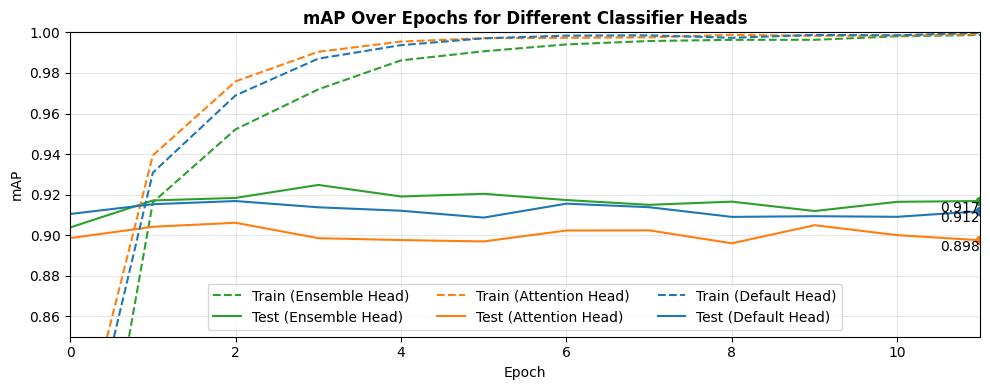

In [10]:
# Load performance data for classifier head experiments
classifier_head_performance_path = RESULTS_DIR / "classifier_head-experiments.csv"
classifier_head_performance = pd.read_csv(classifier_head_performance_path)

# Get best hyperparameter config
best_hyperparameter_id = hyperparameter_performance['test_map'].idxmax()
best_hyperparameter_config = hyperparameter_performance.loc[best_hyperparameter_id, 'title']

# Plot learning curves for all three configurations
plt.figure(figsize=(10, 4))

# Define configurations to plot
configs = [
    {
        'id': classifier_head_performance[classifier_head_performance['title'].str.contains('ensemble')].iloc[0]['id'],
        'title': 'classifier_head=ensemble',
        'label': 'Ensemble Head'
    },
    {
        'id': classifier_head_performance[classifier_head_performance['title'].str.contains('attention')].iloc[0]['id'],
        'title': 'classifier_head=attention', 
        'label': 'Attention Head'
    },
    {
        'id': best_hyperparameter_id,
        'title': best_hyperparameter_config,
        'label': 'Default Head'
    }
]
colors = ['#2ca02c', '#ff7f0e', '#1f77b4']

# Plot each configuration
for i, config in enumerate(configs):
    history = histories[config['id']]
    plt.plot(history['train_map'], label=f'Train ({config["label"]})', linestyle='--', color=colors[i])
    plt.plot(history['test_map'], label=f'Test ({config["label"]})', linestyle='-', color=colors[i])
    # Add text labels for final test values
    final_value = history['test_map'].iloc[-1]
    plt.scatter(len(history['test_map'])-1, final_value, color=colors[i], marker='o')
    plt.text(len(history['test_map'])-1, final_value, f'{final_value:.3f}', 
            verticalalignment='top',
            horizontalalignment='right')

plt.title('mAP Over Epochs for Different Classifier Heads', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.xlim(0, 11)
plt.ylim(0.85, 1)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower center', ncol=3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "classifier_head_learning_curves.png")
plt.show()

In [11]:
best_model_id = 18
predicted_labels_df = predictions[best_model_id]

In [12]:
# Get images which are present in both predicted and true labels
present_in_both = set(predicted_labels_df['image_name']) & set(true_labels_df['image_name'])

# Calculate false positives and false negatives
predicted = predicted_labels_df[predicted_labels_df['image_name'].isin(present_in_both)].iloc[:, 1:]
true = true_labels_df[true_labels_df['image_name'].isin(present_in_both)].iloc[:, 1:]

false_positives = ((predicted == 1) & (true == 0)).sum()
false_negatives = ((predicted == 0) & (true == 1)).sum()
true_positives = ((predicted == 1) & (true == 1)).sum()
true_negatives = ((predicted == 0) & (true == 0)).sum()

# Generate a table of the false positives and negatives for each label
stats_table = pd.DataFrame({
    'Label': VOC_CLASSES.keys(),
    'False Positives': false_positives,
    'False Negatives': false_negatives,
    'True Positives': true_positives,
    'True Negatives': true_negatives,
    'Accuracy': (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives),
    'Precision': true_positives / (true_positives + false_positives),
    'Recall': true_positives / (true_positives + false_negatives),
    'F1 Score': 2 * (true_positives / (true_positives + false_positives)) * (true_positives / (true_positives + false_negatives)) / ((true_positives / (true_positives + false_positives)) + (true_positives / (true_positives + false_negatives))),
    'TP Rate': true_positives / (true_positives + false_negatives),
    'TN Rate': true_negatives / (true_negatives + false_positives),
    'FP Rate': false_positives / (true_positives + false_positives),
    'FN Rate': false_negatives / (true_negatives + false_negatives)
})
stats_table.sort_values(by='F1 Score', ascending=False, inplace=True)
stats_table

,Label,False Positives,False Negatives,True Positives,True Negatives,Accuracy,Precision,Recall,F1 Score,TP Rate,TN Rate,FP Rate,FN Rate
14,person,716,755,1146,807,0.570386,0.615467,0.602841,0.609088,0.602841,0.529875,0.384533,0.483355
2,bird,128,141,15,3140,0.921437,0.104895,0.096154,0.100334,0.096154,0.960832,0.895105,0.042975
6,car,184,240,22,2978,0.876168,0.106796,0.083969,0.094017,0.083969,0.941809,0.893204,0.074580
11,dog,227,250,24,2923,0.860689,0.095618,0.087591,0.091429,0.087591,0.927937,0.904382,0.078790
7,cat,206,218,19,2981,0.876168,0.084444,0.080169,0.082251,0.080169,0.935362,0.915556,0.068146
1,bicycle,107,122,8,3187,0.933119,0.069565,0.061538,0.065306,0.061538,0.967517,0.930435,0.036869
8,chair,172,258,15,2979,0.874416,0.080214,0.054945,0.065217,0.054945,0.945414,0.919786,0.079703
5,bus,78,99,6,3241,0.948306,0.071429,0.057143,0.063492,0.057143,0.976499,0.928571,0.029641
0,aeroplane,120,134,8,3162,0.925818,0.062500,0.056338,0.059259,0.056338,0.963437,0.937500,0.040655
18,train,105,120,7,3192,0.934287,0.062500,0.055118,0.058577,0.055118,0.968153,0.937500,0.036232


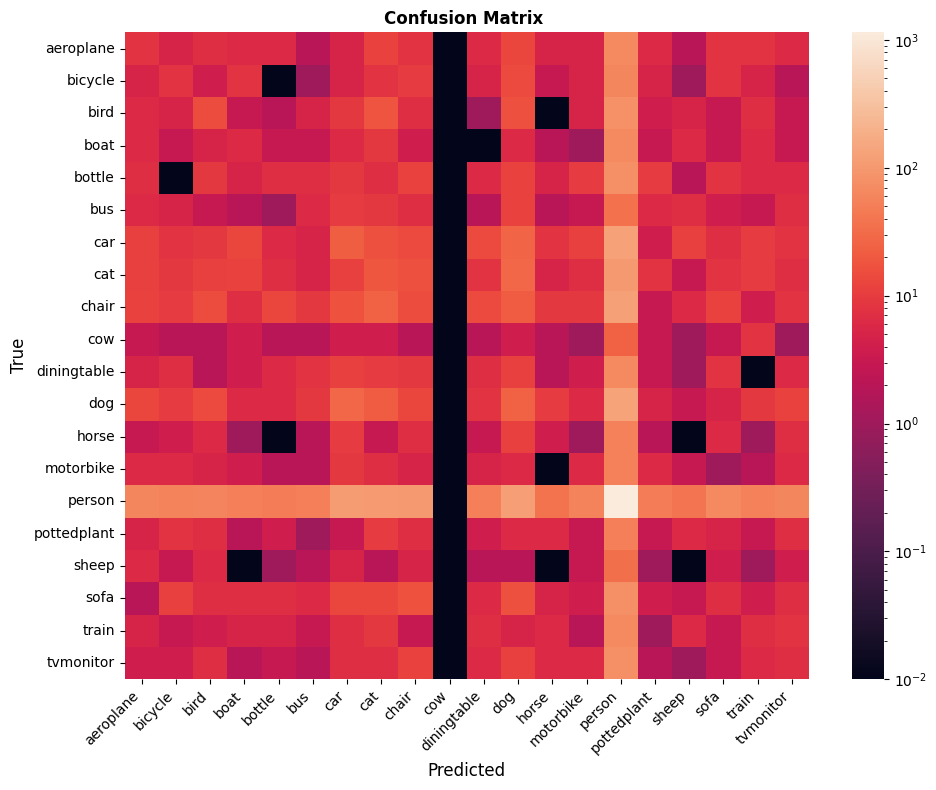

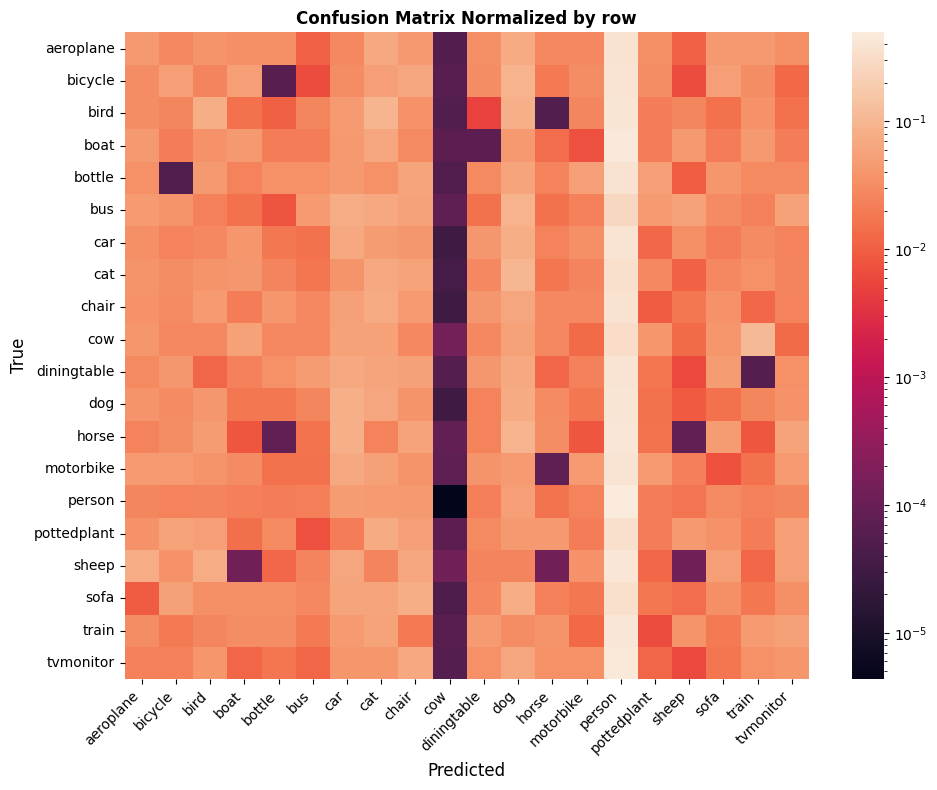

In [13]:
num_labels = true.shape[1]
label_confusion_matrix = np.zeros((num_labels, num_labels), dtype=int)

# Populate the confusion matrix
for i in range(len(true)):
    true_labels = np.where(true.iloc[i] == 1)[0]
    predicted_labels = np.where(predicted.iloc[i] == 1)[0]
    
    for t in true_labels:
        for p in predicted_labels:
            label_confusion_matrix[t, p] += 1

# Convert to DataFrame for better visualization
label_confusion_df = pd.DataFrame(label_confusion_matrix, index=VOC_CLASSES.keys(), columns=VOC_CLASSES.keys())
# Add a small constant to avoid log(0)
label_confusion_df += 0.01

# Optionally normalize the matrix
label_confusion_df_normalized = label_confusion_df.div(label_confusion_df.sum(axis=1), axis=0)

for idx, confusion_df in enumerate([label_confusion_df, label_confusion_df_normalized]):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(confusion_df,
                xticklabels=VOC_CLASSES.keys(), 
                yticklabels=VOC_CLASSES.keys(),
                norm=LogNorm(),
                ax=ax)
    ax.set_xticklabels(VOC_CLASSES.keys(), rotation=45, ha='right')
    ax.set_title(f'Confusion Matrix {["", "Normalized by row"][idx]}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('True', fontsize=12)

    plt.tight_layout()
    plt.savefig(FIGURES_DIR / f'confusion_matrix{["", "_normalized"][idx]}.png')
    plt.show()

## todo
- [x] mAP for model experiments
    - heatmap or grouped bar plot
- [x] mAP for hyperparameter experiments
    - heatmap or grouped bar plot
    - 3 learning rates and 3 batch sizes
    - for batch size, compare 3 learning rates
    - ideally show all 9 in one plot, not too busy
- [ ] mAP for augmentation experiments
    - history plot showing how augmentation reduces overfitting
- [ ] mAP for imbalance experiments
    - heatmap showing mAP for each class before and after balancing
- [x] mAP for classifier head experiments
    - shows a less biased output
    - history, train vs test of default and ensemble
    - you could see that the ensemble has a lower overfitting
- [ ] subset accuracy for the best model
- [ ] confusion matrix / stats for the best model
